In [2]:
import torch
import torchvision
from torch import nn


def conv3x3(i: int, o: int) -> nn.Conv2d:
    """3×3 convolution with padding=1 (same spatial size)."""
    return nn.Conv2d(i, o, kernel_size=3, padding=1, bias=False)


class ConvGelu(nn.Module):
    """Conv → GELU helper block (replacing Conv+ReLU)."""

    def __init__(self, i: int, o: int):
        super().__init__()
        self.block = nn.Sequential(
            conv3x3(i, o),
            nn.GELU(),
        )

    def forward(self, x):
        return self.block(x)


class DecoderBlock(nn.Module):
    """Decoder up‑sampling block: (Conv→GELU) ×1  +  2× upsample via transpose‑conv."""

    def __init__(self, i: int, m: int, o: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvGelu(i, m),
            nn.ConvTranspose2d(m, o, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.GELU(),
        )

    def forward(self, x):
        return self.block(x)


class InvertedBottleneck(nn.Module):
    """MobileNet‑v2 style inverted residual bottleneck.

    Args:
        ch (int): input/output channels.
        exp (int): expansion factor. Default 4 (i.e. ch → ch*exp → ch).
        use_se (bool): whether to use Squeeze-and-Excitation.
    """

    def __init__(self, ch: int, exp: int = 4, use_se: bool = False):
        super().__init__()
        mid = ch * exp
        
        self.expand = nn.Sequential(
            nn.Conv2d(ch, mid, kernel_size=1, bias=False),
            nn.BatchNorm2d(mid),
            nn.GELU(),
        )
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(mid, mid, kernel_size=3, padding=1, groups=mid, bias=False),
            nn.BatchNorm2d(mid),
            nn.GELU(),
        )
        
        # Squeeze-and-Excitation block (optional)
        self.se = None
        if use_se:
            self.se = SqueezeExcitation(mid)
        
        self.project = nn.Sequential(
            nn.Conv2d(mid, ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(ch),
        )

    def forward(self, x):
        residual = x
        x = self.expand(x)
        x = self.depthwise(x)
        if self.se is not None:
            x = self.se(x)
        x = self.project(x)
        return residual + x


class SqueezeExcitation(nn.Module):
    """Squeeze-and-Excitation block for channel attention."""
    
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.GELU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return x * self.se(x)


class MultiScaleBottleneck(nn.Module):
    """Multi-scale bottleneck with different dilation rates."""
    
    def __init__(self, ch: int, exp: int = 4):
        super().__init__()
        mid = ch * exp
        
        # Different dilation rates for multi-scale feature extraction
        self.branch1 = nn.Sequential(
            nn.Conv2d(ch, mid // 4, 1, bias=False),
            nn.BatchNorm2d(mid // 4),
            nn.GELU(),
            nn.Conv2d(mid // 4, mid // 4, 3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(mid // 4),
            nn.GELU(),
        )
        
        self.branch2 = nn.Sequential(
            nn.Conv2d(ch, mid // 4, 1, bias=False),
            nn.BatchNorm2d(mid // 4),
            nn.GELU(),
            nn.Conv2d(mid // 4, mid // 4, 3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(mid // 4),
            nn.GELU(),
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv2d(ch, mid // 4, 1, bias=False),
            nn.BatchNorm2d(mid // 4),
            nn.GELU(),
            nn.Conv2d(mid // 4, mid // 4, 3, padding=4, dilation=4, bias=False),
            nn.BatchNorm2d(mid // 4),
            nn.GELU(),
        )
        
        self.branch4 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch, mid // 4, 1, bias=True),  # 使用 bias=True，避免 BatchNorm
            nn.GELU(),
        )
        
        self.project = nn.Sequential(
            nn.Conv2d(mid, ch, 1, bias=False),
            nn.BatchNorm2d(ch),
        )
    
    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        
        # Upsample branch4 to match spatial dimensions
        b4 = nn.functional.interpolate(b4, size=x.shape[2:], mode='bilinear', align_corners=False)
        
        # Concatenate all branches
        concat = torch.cat([b1, b2, b3, b4], dim=1)
        out = self.project(concat)
        
        return x + out


class EnhancedUNet11_4ch(nn.Module):
    """Enhanced UNet‑11 with multiple bottleneck improvements."""

    def __init__(self, num_filters: int = 32, pretrained: bool = True, bottleneck_type: str = 'multi'):
        super().__init__()
        
        # ─────── Encoder (VGG11) ────────────────────────────────────────────
        enc = torchvision.models.vgg11(pretrained=pretrained).features

        # First conv: 4→64 (copy RGB weights and set 4th channel to mean)
        old_conv1 = enc[0]  # 3→64
        new_conv1 = nn.Conv2d(4, 64, kernel_size=3, padding=1, bias=False)
        if pretrained:
            with torch.no_grad():
                new_conv1.weight[:, :3] = old_conv1.weight  # copy RGB
                new_conv1.weight[:, 3:4] = old_conv1.weight.mean(dim=1, keepdim=True)
        enc[0] = new_conv1
        self.encoder = enc

        # Shortcut handles
        self.gelu = nn.GELU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1, self.conv2 = enc[0], enc[3]
        self.conv3s, self.conv3 = enc[6], enc[8]
        self.conv4s, self.conv4 = enc[11], enc[13]
        self.conv5s, self.conv5 = enc[16], enc[18]

        # ─────── Enhanced Decoder with Bottlenecks ──────────────────────────
        nf = num_filters
        
        # 確保通道數匹配
        self.center = DecoderBlock(nf * 16, nf * 8 * 2, nf * 8)  # 512 -> 256 -> 256
        
        # Add bottlenecks in decoder layers
        self.dec5 = DecoderBlock(nf * (8 + 16), nf * 8 * 2, nf * 8)  # 768 -> 512 -> 256
        self.dec5_bottleneck = self._create_bottleneck(nf * 8, bottleneck_type)
        
        self.dec4 = DecoderBlock(nf * (8 + 16), nf * 8 * 2, nf * 4)  # 768 -> 512 -> 128
        self.dec4_bottleneck = self._create_bottleneck(nf * 4, bottleneck_type)
        
        self.dec3 = DecoderBlock(nf * (4 + 8), nf * 4 * 2, nf * 2)  # 384 -> 256 -> 64
        self.dec3_bottleneck = self._create_bottleneck(nf * 2, bottleneck_type)
        
        self.dec2 = DecoderBlock(nf * (2 + 4), nf * 2 * 2, nf)  # 192 -> 128 -> 32
        self.dec2_bottleneck = self._create_bottleneck(nf, bottleneck_type)
        
        self.dec1 = ConvGelu(nf * (1 + 2), nf)  # 96 -> 32

        # ─────── Multiple Final Bottlenecks ──────────────────────────────────
        self.final_bottlenecks = nn.ModuleList([
            self._create_bottleneck(nf, bottleneck_type) for _ in range(3)
        ])
        
        # Final convolution
        self.final = nn.Conv2d(nf, 1, kernel_size=1)

    def _create_bottleneck(self, channels: int, bottleneck_type: str):
        """Create bottleneck based on type."""
        if bottleneck_type == 'multi':
            return MultiScaleBottleneck(channels, exp=4)
        elif bottleneck_type == 'se':
            return InvertedBottleneck(channels, exp=4, use_se=True)
        else:  # 'standard'
            return InvertedBottleneck(channels, exp=4, use_se=False)

    def _enc_forward(self, x):
        c1 = self.gelu(self.conv1(x))
        c2 = self.gelu(self.conv2(self.pool(c1)))
        c3s = self.gelu(self.conv3s(self.pool(c2)))
        c3 = self.gelu(self.conv3(c3s))
        c4s = self.gelu(self.conv4s(self.pool(c3)))
        c4 = self.gelu(self.conv4(c4s))
        c5s = self.gelu(self.conv5s(self.pool(c4)))
        c5 = self.gelu(self.conv5(c5s))
        return c1, c2, c3, c4, c5

    def forward(self, x):
        c1, c2, c3, c4, c5 = self._enc_forward(x)
        ctr = self.center(self.pool(c5))

        # Enhanced decoder with bottlenecks
        d5 = self.dec5(torch.cat([ctr, c5], dim=1))
        d5 = self.dec5_bottleneck(d5)
        
        d4 = self.dec4(torch.cat([d5, c4], dim=1))
        d4 = self.dec4_bottleneck(d4)
        
        d3 = self.dec3(torch.cat([d4, c3], dim=1))
        d3 = self.dec3_bottleneck(d3)
        
        d2 = self.dec2(torch.cat([d3, c2], dim=1))
        d2 = self.dec2_bottleneck(d2)
        
        d1 = self.dec1(torch.cat([d2, c1], dim=1))

        # Apply multiple final bottlenecks
        out = d1
        for bottleneck in self.final_bottlenecks:
            out = bottleneck(out)
        
        return self.final(out)


# 使用示例
if __name__ == "__main__":
    # 三種不同的瓶頸配置
    model_multi = EnhancedUNet11_4ch(num_filters=32, bottleneck_type='multi')
    model_se = EnhancedUNet11_4ch(num_filters=32, bottleneck_type='se')
    model_standard = EnhancedUNet11_4ch(num_filters=32, bottleneck_type='standard')
    
    # 測試輸入
    x = torch.randn(1, 4, 256, 256)
    
    with torch.no_grad():
        out_multi = model_multi(x)
        out_se = model_se(x)
        out_standard = model_standard(x)
    
    print(f"Multi-scale output shape: {out_multi.shape}")
    print(f"SE output shape: {out_se.shape}")
    print(f"Standard output shape: {out_standard.shape}")

Multi-scale output shape: torch.Size([1, 1, 256, 256])
SE output shape: torch.Size([1, 1, 256, 256])
Standard output shape: torch.Size([1, 1, 256, 256])


In [ ]:
# train_unet4ch.py
import os, csv, random, argparse
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
#from model import UNet11_4ch                 # ★★ 改成 4ch 版本

# ---------------- Dataset ----------------
class AerialPatchDataset4C(Dataset):
    """
    root/
     ├─ images/        austin1.tif ...
     ├─ depth_images/  austin1_depth.png / tif / jpg ...
     └─ gt/            austin1.tif (遮罩，與 images 同名)
    """
    COMMON_EXTS = [".png", ".jpg", ".jpeg", ".tif", ".tiff"]

    def __init__(self, root, crop=256):
        self.crop      = crop
        self.img_dir   = os.path.join(root, "images")
        self.depth_dir = os.path.join(root, "depth_images")
        self.mask_dir  = os.path.join(root, "gt")

        self.names     = sorted(os.listdir(self.img_dir))           # ex: austin1.tif
        self.depth_map = self._build_depth_map()                    # ★★ 建對應表

        self.mean = torch.tensor([0.485,0.456,0.406,0.5]).view(4,1,1)
        self.std  = torch.tensor([0.229,0.224,0.225,0.5]).view(4,1,1)

    # ----------  新增：掃描 depth_images ----------
    def _build_depth_map(self):
        depth_files = os.listdir(self.depth_dir)
        depth_dict  = {}
        for f in depth_files:
            stem, ext = os.path.splitext(f)
            if stem.endswith("_depth"):
                base = stem[:-6]                    # 去掉 "_depth"
                depth_dict[base] = f
        return depth_dict                           # {austin1: austin1_depth.png}

    def __len__(self): return len(self.names)

    def _random_crop(self, img, depth, msk):
        h, w = img.shape[:2]; ch = cw = self.crop
        top  = random.randint(0, h - ch); left = random.randint(0, w - cw)
        return (arr[top:top+ch, left:left+cw] for arr in (img, depth, msk))

    def __getitem__(self, idx):
        name = self.names[idx]                      # austin1.tif
        stem, ext = os.path.splitext(name)          # austin1, .tif
        try:
            # --- 找對應的深度圖檔名 ---
            if stem in self.depth_map:
                depth_fname = self.depth_map[stem]
            else:
                # 保險：按副檔名猜測
                depth_fname = None
                for ex in [ext] + self.COMMON_EXTS:
                    cand = f"{stem}_depth{ex}"
                    if os.path.exists(os.path.join(self.depth_dir, cand)):
                        depth_fname = cand; break
                if depth_fname is None:
                    raise FileNotFoundError(f"找不到 {stem}_depth.*")

            # --- 讀檔 ---
            rgb   = Image.open(os.path.join(self.img_dir,   name)).convert("RGB")
            depth = Image.open(os.path.join(self.depth_dir, depth_fname)).convert("L")
            msk   = Image.open(os.path.join(self.mask_dir,  name)).convert("L")

            rgb   = np.asarray(rgb)
            depth = np.asarray(depth)[..., None]              # H×W×1
            msk   = (np.asarray(msk) // 255).astype(np.uint8)

            rgb, depth, msk = self._random_crop(rgb, depth, msk)

            # --- to tensor ---
            rgb   = torch.from_numpy(rgb).permute(2,0,1).float() / 255.0
            depth = torch.from_numpy(depth).permute(2,0,1).float() / 255.0
            img4  = torch.cat([rgb, depth], 0)                # 4×H×W
            img4  = (img4 - self.mean) / self.std
            msk   = torch.from_numpy(msk).float().unsqueeze(0)
            return img4, msk

        except Exception as e:
            print(f"❌ [錯誤] {name}: {e}")
            return (torch.zeros(4, self.crop, self.crop),
                    torch.zeros(1, self.crop, self.crop))

# ---------------- Metric -----------------
def dice_coef(pred, target, eps=1e-7):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * target).sum((1,2,3))
    union = pred.sum((1,2,3)) + target.sum((1,2,3))
    return ((2*inter+eps)/(union+eps)).mean()

# ---------------- Train ------------------
def main(args):
    torch.multiprocessing.set_start_method('spawn', force=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("🚀 Device:", device)

    root = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\train"
    if not os.path.exists(root):
        print(f"❌ 找不到資料目錄 {root}"); return

    data = AerialPatchDataset4C(root, crop=args.crop)
    print(f"📊 共 {len(data)} 張影像")
    v = int(0.1*len(data))
    train_ds, val_ds = torch.utils.data.random_split(data, [len(data)-v, v])

    def loader(ds, shf): return DataLoader(
        ds, batch_size=args.bs, shuffle=shf,
        num_workers=0, pin_memory=False, persistent_workers=False)

    train_ld, val_ld = loader(train_ds, True), loader(val_ds, False)

    model = EnhancedUNet11_4ch(pretrained=True).to(device)      # ★★
    crit  = nn.BCEWithLogitsLoss()
    opt   = torch.optim.Adam(model.parameters(), lr=args.lr)
    scaler= torch.amp.GradScaler(device.type)

    best = 0; os.makedirs("checkpoints", exist_ok=True)
    with open("metrics.csv","w",newline="") as f:
        csv.writer(f).writerow(["epoch","train_loss","val_loss","dice"])

    for ep in range(1, args.epochs+1):
        # ---- train ----
        model.train(); tr_loss=0; n_tr=0
        for img,msk in tqdm(train_ld, desc=f"Ep{ep}/{args.epochs} train"):
            img,msk = img.to(device), msk.to(device)
            with torch.amp.autocast(device.type):
                pred = model(img); loss = crit(pred, msk)
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            tr_loss += loss.item(); n_tr += 1

        # ---- val ----
        model.eval(); vl_loss=0; dices=[]; n_v=0
        with torch.no_grad():
            for img,msk in tqdm(val_ld, desc=f"Ep{ep}/{args.epochs} val"):
                img,msk = img.to(device), msk.to(device)
                with torch.amp.autocast(device.type):
                    pred = model(img); loss = crit(pred, msk)
                vl_loss += loss.item(); dices.append(dice_coef(pred, msk).item()); n_v += 1

        tr_loss /= max(n_tr,1); vl_loss /= max(n_v,1); dice = np.mean(dices) if dices else 0
        print(f"📝 Ep{ep} train={tr_loss:.4f} val={vl_loss:.4f} dice={dice:.4f}")
        with open("metrics.csv","a",newline="") as f:
            csv.writer(f).writerow([ep,tr_loss,vl_loss,dice])

        if dice > best:
            best = dice
            torch.save(model.state_dict(), "checkpoints/best_unet4ch(Enhanced_UNet11_4ch).pth")
            print(f"  👑  Saved best model (dice {best:.4f})")

# ---------------- Run --------------------
if __name__ != "__main__":
    args = argparse.Namespace(epochs=100, bs=4, lr=1e-4, crop=256)
    main(args)


🚀 Device: cuda
📊 共 180 張影像


c:\Users\op237\miniconda3\envs\Depth4UNet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Ep1/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep1 train=0.5454 val=0.3957 dice=0.3539
  👑  Saved best model (dice 0.3539)


Ep2/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep2 train=0.3397 val=0.3579 dice=0.5737
  👑  Saved best model (dice 0.5737)


Ep3/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep3 train=0.2939 val=0.1926 dice=0.7265
  👑  Saved best model (dice 0.7265)


Ep4/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep4 train=0.2576 val=0.2181 dice=0.6313


Ep5/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep5 train=0.2579 val=0.1634 dice=0.7018


Ep6/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep6 train=0.2595 val=0.3621 dice=0.5162


Ep7/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep7 train=0.2418 val=0.2246 dice=0.5381


Ep8/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep8 train=0.2009 val=0.2743 dice=0.7488
  👑  Saved best model (dice 0.7488)


Ep9/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep9 train=0.2247 val=0.1429 dice=0.6982


Ep10/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep10 train=0.2072 val=0.2367 dice=0.5511


Ep11/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep11 train=0.2405 val=0.1900 dice=0.7528
  👑  Saved best model (dice 0.7528)


Ep12/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep12 train=0.2063 val=0.1590 dice=0.7896
  👑  Saved best model (dice 0.7896)


Ep13/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep13 train=0.1962 val=0.2518 dice=0.5684


Ep14/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep14 train=0.2249 val=0.1427 dice=0.7375


Ep15/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep15 train=0.2105 val=0.1592 dice=0.6806


Ep16/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep16 train=0.1756 val=0.1773 dice=0.6475


Ep17/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep17 train=0.2137 val=0.2077 dice=0.7524


Ep18/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep18 train=0.1912 val=0.1385 dice=0.6779


Ep19/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep19 train=0.1715 val=0.2099 dice=0.8054
  👑  Saved best model (dice 0.8054)


Ep20/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep20 train=0.1726 val=0.1959 dice=0.7362


Ep21/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep21 train=0.2019 val=0.1706 dice=0.6953


Ep22/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep22 train=0.1936 val=0.1681 dice=0.6948


Ep23/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep23 train=0.2400 val=0.2238 dice=0.6619


Ep24/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep24 train=0.1722 val=0.1995 dice=0.6788


Ep25/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep25 train=0.1886 val=0.1783 dice=0.7478


Ep26/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep26 train=0.1791 val=0.2112 dice=0.8348
  👑  Saved best model (dice 0.8348)


Ep27/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep27 train=0.2088 val=0.1838 dice=0.7958


Ep28/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


📝 Ep28 train=0.1808 val=0.1475 dice=0.6578


Ep29/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep29 train=0.1636 val=0.1193 dice=0.8031


Ep30/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep30 train=0.2099 val=0.2008 dice=0.7228


Ep31/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep31 train=0.1790 val=0.2662 dice=0.6265


Ep32/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep32 train=0.1768 val=0.1779 dice=0.7424


Ep33/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep33 train=0.1757 val=0.1606 dice=0.8324


Ep34/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep34 train=0.1636 val=0.1271 dice=0.7129


Ep35/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


📝 Ep35 train=0.1672 val=0.1865 dice=0.7326


Ep36/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep36 train=0.1432 val=0.1654 dice=0.6771


Ep37/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep37 train=0.2007 val=0.2725 dice=0.7247


Ep38/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep38 train=0.1696 val=0.1718 dice=0.5983


Ep39/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep39 train=0.1426 val=0.1214 dice=0.6653


Ep40/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


📝 Ep40 train=0.1884 val=0.1571 dice=0.7496


Ep41/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep41 train=0.1866 val=0.1803 dice=0.7426


Ep42/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep42 train=0.1595 val=0.2091 dice=0.7514


Ep43/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


📝 Ep43 train=0.1658 val=0.2138 dice=0.6789


Ep44/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep44 train=0.1790 val=0.2409 dice=0.5885


Ep45/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep45 train=0.1558 val=0.2012 dice=0.7839


Ep46/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep46 train=0.1586 val=0.1443 dice=0.7788


Ep47/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep47 train=0.1479 val=0.1446 dice=0.7193


Ep48/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep48 train=0.1635 val=0.1226 dice=0.6761


Ep49/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep49 train=0.1853 val=0.2491 dice=0.6598


Ep50/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep50 train=0.1669 val=0.1434 dice=0.6612


Ep51/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep51 train=0.1562 val=0.2182 dice=0.5615


Ep52/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep52 train=0.1451 val=0.1799 dice=0.6364


Ep53/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep53 train=0.1564 val=0.1291 dice=0.8010


Ep54/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep54 train=0.1418 val=0.2272 dice=0.7361


Ep55/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep55 train=0.1454 val=0.1373 dice=0.8064


Ep56/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep56 train=0.1544 val=0.1192 dice=0.5857


Ep57/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep57 train=0.1686 val=0.2098 dice=0.6803


Ep58/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep58 train=0.1355 val=0.1264 dice=0.7860


Ep59/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep59 train=0.1372 val=0.1241 dice=0.7495


Ep60/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep60 train=0.1499 val=0.1221 dice=0.7798


Ep61/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep61 train=0.1584 val=0.0933 dice=0.7458


Ep62/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


📝 Ep62 train=0.1495 val=0.1154 dice=0.8060


Ep63/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep63 train=0.1593 val=0.2151 dice=0.5789


Ep64/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep64 train=0.1471 val=0.2264 dice=0.6983


Ep65/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep65 train=0.1686 val=0.1693 dice=0.6578


Ep66/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep66 train=0.1658 val=0.1661 dice=0.5991


Ep67/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep67 train=0.1879 val=0.2804 dice=0.6964


Ep68/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep68 train=0.1908 val=0.0798 dice=0.8016


Ep69/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep69 train=0.1751 val=0.1158 dice=0.5680


Ep70/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep70 train=0.1345 val=0.2104 dice=0.8045


Ep71/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep71 train=0.1381 val=0.2130 dice=0.6862


Ep72/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep72 train=0.1419 val=0.1494 dice=0.7378


Ep73/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep73 train=0.1311 val=0.1496 dice=0.7122


Ep74/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep74 train=0.1651 val=0.2916 dice=0.6853


Ep75/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep75 train=0.1711 val=0.1521 dice=0.6798


Ep76/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep76 train=0.1328 val=0.1578 dice=0.6755


Ep77/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep77 train=0.1832 val=0.1860 dice=0.7749


Ep78/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep78 train=0.1378 val=0.1557 dice=0.8474
  👑  Saved best model (dice 0.8474)


Ep79/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep79 train=0.1274 val=0.1066 dice=0.6551


Ep80/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep80 train=0.1512 val=0.1622 dice=0.8673
  👑  Saved best model (dice 0.8673)


Ep81/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep81 train=0.1423 val=0.1345 dice=0.7281


Ep82/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep82 train=0.1319 val=0.1268 dice=0.8558


Ep83/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep83 train=0.1467 val=0.3601 dice=0.7872


Ep84/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep84 train=0.1446 val=0.1576 dice=0.7627


Ep85/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep85 train=0.1328 val=0.1000 dice=0.6923


Ep86/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep86 train=0.1506 val=0.2363 dice=0.7127


Ep87/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep87 train=0.1644 val=0.1792 dice=0.7746


Ep88/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep88 train=0.1826 val=0.1613 dice=0.6285


Ep89/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep89 train=0.1311 val=0.1676 dice=0.7262


Ep90/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep90 train=0.1192 val=0.1124 dice=0.8095


Ep91/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep91 train=0.1648 val=0.1562 dice=0.6782


Ep92/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep92 train=0.1543 val=0.1616 dice=0.7644


Ep93/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep93 train=0.1775 val=0.2095 dice=0.7962


Ep94/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep94 train=0.1675 val=0.2502 dice=0.6634


Ep95/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


📝 Ep95 train=0.1535 val=0.2348 dice=0.7115


Ep96/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep96 train=0.1523 val=0.2000 dice=0.6935


Ep97/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep97 train=0.1570 val=0.1638 dice=0.5532


Ep98/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep98 train=0.1847 val=0.1776 dice=0.6324


Ep99/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📝 Ep99 train=0.1571 val=0.1658 dice=0.7944


Ep100/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]

📝 Ep100 train=0.1527 val=0.1198 dice=0.7915


🚀 Device: cuda


C:\Users\op237\AppData\Local\Temp\ipykernel_25352\1178210388.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


UNet4ch: matched 351 / 351 layers


Infer val: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Collected 1,179,648 pixels for evaluation
Average Precision = 0.8549
📈  Saved pr_curve.png
💾  Saved val_pred.npz


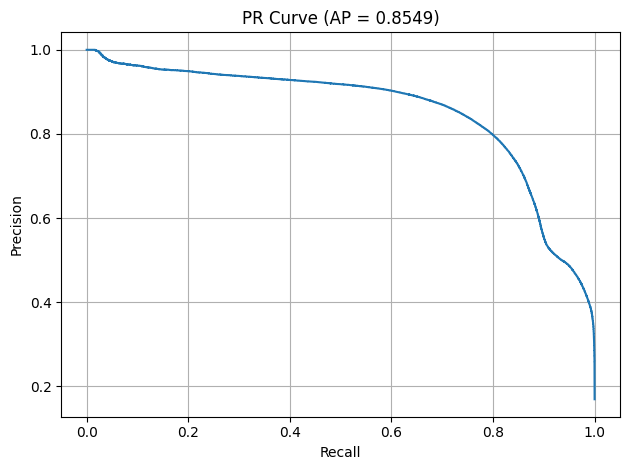

In [6]:
# %% [markdown]
# # Evaluate **UNet11_4ch** & Plot Precision-Recall Curve
#
# 1. 先設定 `CKPT_PATH` 與 `DATA_ROOT`  
# 2. Run all cells / 執行整支 script  
# 3. 會列出 matched layers、計算 PR 曲線與 AP，並存出
#    * `pr_curve.png`
#    * `val_pred.npz`

# %% [markdown]
# ## （可選）安裝相依套件
# 如果缺 `scikit-learn` / `matplotlib`，取消註解以下一行安裝
# !pip install scikit-learn matplotlib tqdm
# ── 固定隨機種子，請放在 import 後、任何資料集/模型建立之前 ──
import random, numpy as np, torch

SEED = 10               # 你想用的種子數
random.seed(SEED)       # Python 內建 random
np.random.seed(SEED)    # NumPy
torch.manual_seed(SEED) # PyTorch CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)      # PyTorch GPU
torch.backends.cudnn.deterministic = True # 讓 cuDNN 算子 deterministic
torch.backends.cudnn.benchmark = False    # 關掉自適應演算法選擇

# %% Imports & helpers
import os, torch, numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score

# ---- 匯入你的模型與 Dataset ----


def load_ckpt(model, ckpt_path, label="UNet4ch"):
    """安全載入權重並回報相符層數"""
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model_state = model.state_dict()
    compatible = {k: v for k, v in ckpt.items()
                  if k in model_state and v.shape == model_state[k].shape}
    model_state.update(compatible)
    model.load_state_dict(model_state)
    print(f"{label}: matched {len(compatible)} / {len(model_state)} layers")
    return model

# %% 🔧 路徑與參數（請修改這裡）
CKPT_PATH  = r"checkpoints/best_unet4ch(Enhanced_UNet11_4ch).pth"  # ← 你的 checkpoint
DATA_ROOT  = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\train"  # ← 資料集根目錄
BATCH_SIZE = 4
CROP_SIZE  = 256
VAL_RATIO  = 0.10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Device:", device)

# %% Dataset & DataLoader
ds = AerialPatchDataset4C(DATA_ROOT, crop=CROP_SIZE)
val_len = int(len(ds) * VAL_RATIO)
_, val_ds = torch.utils.data.random_split(ds, [len(ds) - val_len, val_len])

val_ld = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=False)

# %% Model
model = EnhancedUNet11_4ch(pretrained=False).to(device)
model = load_ckpt(model, CKPT_PATH)

# %% Inference: collect y_true / y_score
model.eval()
y_true, y_score = [], []
with torch.no_grad():
    for img, msk in tqdm(val_ld, desc="Infer val"):
        img = img.to(device)
        prob = model(img).sigmoid().cpu()   # (B,1,H,W) 機率
        y_score.append(prob.flatten())
        y_true.append(msk.flatten())

y_true  = torch.cat(y_true).numpy()
y_score = torch.cat(y_score).numpy()
print(f"Collected {y_true.shape[0]:,} pixels for evaluation")

# %% PR curve & Average Precision
precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)
print(f"Average Precision = {ap:.4f}")

# %% Plot & save
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR Curve (AP = {ap:.4f})")
plt.grid()
plt.tight_layout()
plt.savefig("pr_curve.png")
print("📈  Saved pr_curve.png")

# Save raw arrays
np.savez_compressed("val_pred.npz", y_true=y_true, y_score=y_score)
print("💾  Saved val_pred.npz")
